<a href="https://colab.research.google.com/github/Jalalij/LIS-DeepLearning/blob/master/x_data_y_data_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Beam Managment as a Regression Problem**


# Mounting Google Drive in Google Colab


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Code Explanation: `prepData` Class

The `prepData` class in the code contains methods for generating specific patterns of indices based on given parameters.

In [4]:
class prepData:

    PRESET_K_FOR_FIXED_BPATTERN = 5
    @staticmethod
    def GetBPatternIdxsNonIncremental(N, blen, presetk):
        idxs = np.linspace(0, N-1, blen).astype(int) + presetk
        return np.array(sorted(list(map(lambda x: x % N, idxs))))

    @staticmethod
    def GetBPatternIdxs(N, blen, presetk):  # incremental version
        if blen == 64 and presetk == prepData.PRESET_K_FOR_FIXED_BPATTERN:
            idxs = [ 0, 7, 8, 15, 17, 23, 24, 30, 34, 38, 41, 45, 51, 54, 57, 60, 65, 68, 75, 78,
                         82, 85, 90, 93, 99, 102, 105, 112, 119, 120, 123, 127, 128, 131, 135, 136, 138,
                         142, 150, 153, 162, 165, 170, 173, 177, 180, 183, 187, 195, 198, 201, 204,
                         210, 213, 218, 221, 225, 231, 232, 238, 240, 247, 247, 255]
            return idxs
        # print(' -> computing linear BPattern: N=%d, blen=%d, presetk=%d' % (N, blen, presetk))
        wrapidx = lambda x: x if x >= 0 else x + N
        S = set([wrapidx(N//4 - presetk), wrapidx(3*N//4 - presetk)])
        for f in (16, 8, 4, 2): #lk in range(2, lkmax+1): # pow(2,1)=2 to pow(2,6)=64
            if len(S) == blen:
                break
            cnt = N//f # min(N//f, blen-len(S))
            adds = [f*k for k in range(1,cnt)]
            for i,x in enumerate(adds): # [:(blen-len(S))]:
                xx = wrapidx(x - presetk - i)
                S2 = S | set([xx])
                if len(S2) > len(S) and len(S2) <= blen:
                    S = S2
                    # print(' -> len(S)=%d, f=%d, cnt=%d, after adding x=%d, S=%s, adds=%s' % (len(S), f, cnt, x, sorted(list(S)), adds))
                    # print(' -> after adding x=%d, d=%d, f=%d, cnt=%d, adds=%s, S=%s, len(S)=%d' %
                    #   (lk, d, f, cnt-1, adds, S, len(S)))
        return sorted(list(S))

# easyDataloader Function

The `easyDataloader` function is a Python utility designed for loading data from files, specifically supporting both '.npy' (NumPy array files) and '.pkl' (pickle files).

In [5]:
"""
Created on Tue Dec 4 10:04:35 2023

@author: jalal
"""

import sys
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt


def easyDataloader(fpath):
    """
    easyDataloader Function
    The function supports loading from '.npy' and pickle ('.pkl') files.

    Parameters:
    fpath (str): The file path of the data file to be loaded.

    Returns:
    Return the loaded data
    """
    # Extract the file extension from the file path to determine the file type
    ext = fpath.split('.')[-1].lower()

    # Define an internal function for loading pickle files
    def _pklLoader(fpath):
        # Informing the user that the pickle loading process has started
        print(' -> pkloader, loading from: %s, ext=%s... ' % (fpath, ext), end='')

        # Open and load the pickle file
        with open(fpath, 'rb') as file:
            data = pkl.load(file)

        # Check if the loaded data is a dictionary
        dataisDD = type(data) is dict

        # If data is a dictionary, try to retrieve data associated with the 'rsrp' key
        if dataisDD:
            if 'rsrp' in data:
                data = data['rsrp']
            else:
                # If 'rsrp' key is not found, output an error and exit the program
                print('\n ==> Error _pklLoader got dict but no rsrp key\n   -> fpath=%s\n    -> dd.keys: %s\n\n' % (fpath, data.keys()))
                sys.exit(-1)
        return data

    # Determine the appropriate loader function based on the file extension
    loader = np.load if ext == 'npy' else _pklLoader

    # Load the data using the selected loader function
    data = loader(fpath)

    # Informing the user of the successful data load
    print(' -> loading from: %s, ext=%s... got: \n  -> %s' % (fpath, ext, data))

    # Return the loaded data
    return data


# Uploading Data in a Specified Directory

This code snippet demonstrates the process of loading a data file from a specified directory, particularly from a Google Drive directory when working in a Google Colab environment. It utilizes the previously discussed `easyDataloader` function for data loading.

In [6]:
# upload the data in a directory of your choice
dataDir = '/content/drive/MyDrive/regression_problem/data_npy'
data_name = '/processed_rsrp_bst_rx_umi_uma.npy'
data_name = '/processed_rsrp_bst_rx_32x1_524288_1024UE_tx_32_indoor20_wo_SC_default_cluster_C_20230804_123305.npy'
fname = dataDir + data_name
_rawData = easyDataloader(fname)

 -> loading from: /content/drive/MyDrive/regression_problem/data_npy/processed_rsrp_bst_rx_32x1_524288_1024UE_tx_32_indoor20_wo_SC_default_cluster_C_20230804_123305.npy, ext=npy... got: 
  -> [[ -88.75314499  -77.14872481  -79.55661402 ...  -69.23797925
   -72.40235797  -54.39824452]
 [ -71.37112322  -87.47744453  -59.86277527 ...  -90.80840704
   -72.89914256  -73.14614798]
 [-131.63571314 -121.71979339 -114.50317071 ... -126.08874352
  -124.22857684 -108.31827401]
 ...
 [ -76.48051861  -84.81008757  -62.13328083 ...  -79.01981358
   -56.3397604   -80.86505277]
 [ -73.66799437  -66.85643321  -54.58370915 ...  -67.18717965
   -57.30622408  -54.50018522]
 [-144.19761432 -140.47091746 -122.89530827 ... -135.2553118
  -117.0663885  -132.31134104]]


# Data Processing and Visualization Code Explanation

The provided Python code consists of functions for processing and visualizing data, particularly in the context of beam pattern analysis.

In [7]:
"""
Created on Tue Nov 30 10:04:35 2023

@author: jalal
"""

import os, sys
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

# Constants
SET_B_LEN = 8
# RAND_DRAW_PER_SAMPLE = 1

def get_indices(pattern, total_beams, set_b_len, sample=None, total_preset=None):
    """
    Generate indices based on the specified pattern.

    Parameters:
    pattern (str): Type of pattern ('fixed', 'random', or 'preset').
    total_beams (int): Total number of beams.
    set_b_len (int): Length of the set B.
    sample (int, optional): Sample number, used for 'preset' pattern.
    total_preset (int, optional): Total number of presets, used for 'preset' pattern.

    Returns:
    numpy.ndarray: Array of indices.
    """
    if pattern == 'fixed':
        return prepData.GetBPatternIdxs(total_beams, set_b_len, 5)
        # return prepData.GetBPatternIdxsNonIncremental(total_beams, set_b_len, 5)
    elif pattern == 'random':
        return np.random.choice(total_beams, set_b_len, replace=False).astype(int)
    elif pattern == 'preset':
        if sample is None or total_preset is None:
            raise ValueError("Sample and total_preset must be provided for 'preset' pattern")
        return prepData.GetBPatternIdxs(total_beams, set_b_len, sample % total_preset)
        # return prepData.GetBPatternIdxsNonIncremental(total_beams, set_b_len, sample % total_preset)
    else:
        raise ValueError("Invalid pattern type")

def get_x_data_y_data(raw_data, set_b_pattern_string, miss_val_rep):
    """
    Process raw data to generate xData and yData based on the specified beam pattern.

    Parameters:
    raw_data (numpy.ndarray): The input raw data.
    set_b_pattern_string (str): The pattern string indicating the type of beam pattern.
    miss_val_rep: Representation for missing values.

    Returns:
    tuple: A tuple containing processed xData, yData, and repData.
    """

    # Initialization
    nsamples, total_beams = raw_data.shape
    lowest_possible_rsrp = np.min(raw_data)
    x_data = np.ones(raw_data.shape) * lowest_possible_rsrp
    y_data = raw_data
    # rep_data = None
    idxs_text = ''

    if set_b_pattern_string == 'fixed':
        idxs = get_indices('fixed', total_beams, SET_B_LEN)
        print(print("Indices: %s" % idxs))
        x_data[:, idxs] = raw_data[:, idxs]
        idxs_text = ';'.join(map(str, idxs))
        print('idxs_text =%s' % idxs_text)

    elif set_b_pattern_string == 'random':
        x_data = np.ones((nsamples, total_beams)) * lowest_possible_rsrp
        for sample in range(nsamples):
            idxs = get_indices('random', total_beams, SET_B_LEN)
            x_data[sample, idxs] = raw_data[sample, idxs]
        idxs_text = 'random'
        # rep_data = np.repeat(raw_data, RAND_DRAW_PER_SAMPLE, axis=0)

    elif set_b_pattern_string == 'preset':
        total_preset = 5
        for sample in range(nsamples):
            idxs = get_indices('preset', total_beams, SET_B_LEN, sample, total_preset)
            x_data[sample, idxs] = raw_data[sample, idxs]
        idxs_text = '|'.join([';'.join(map(str, get_indices('preset', total_beams, SET_B_LEN, k, total_preset))) for k in range(total_preset)])
        print('idxs_text =%s' % idxs_text)
    else:
        raise ValueError("Invalid setBpatternString value")


    # scale the x_data, y_data
    # x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))
    # y_data = (y_data-np.min(y_data))/(np.max(y_data)-np.min(y_data))

    plot_data_statistics(raw_data, 'raw_data')  # Replace 'example_filename' with actual file name

    return x_data, y_data

def plot_data_statistics(data, filename):
    """
    Plot statistics of the data.

    Parameters:
    data (numpy.ndarray): Data to be plotted.
    filename (str): The name of the file for title.
    """
    plt.close('all')
    plt.suptitle(filename.replace('.txt', ''))
    x = np.random.choice(data.flatten(), size=int(0.1 * len(data.flatten())))
    plt.hist(x, bins=137)
    plt.axvline(np.mean(data), color='k', linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(np.median(data), color='blue', linestyle='dashed', linewidth=1, label='Median')
    plt.legend(['Mean', 'Median'])
    plt.show()

Indices: [2, 3, 5, 10, 11, 17, 19, 31]
None
idxs_text =2;3;5;10;11;17;19;31


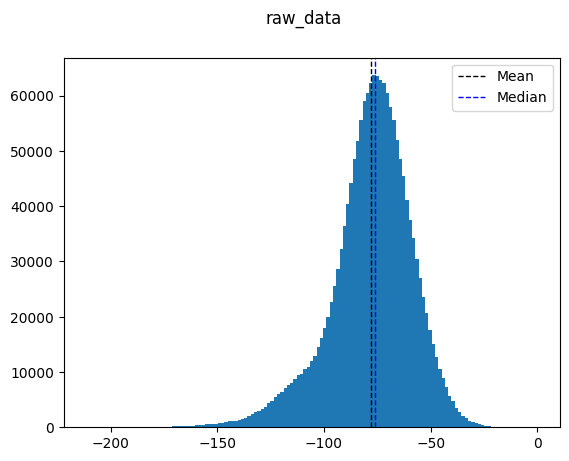

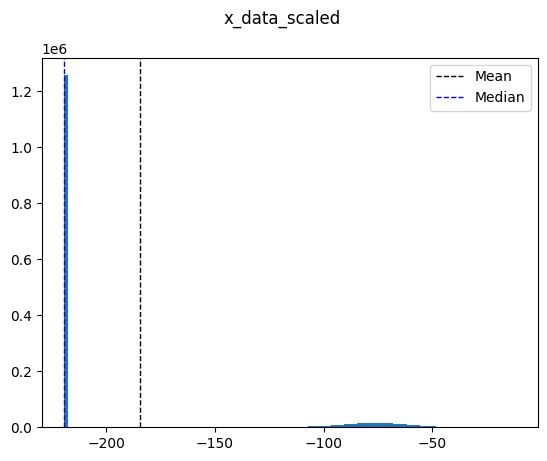

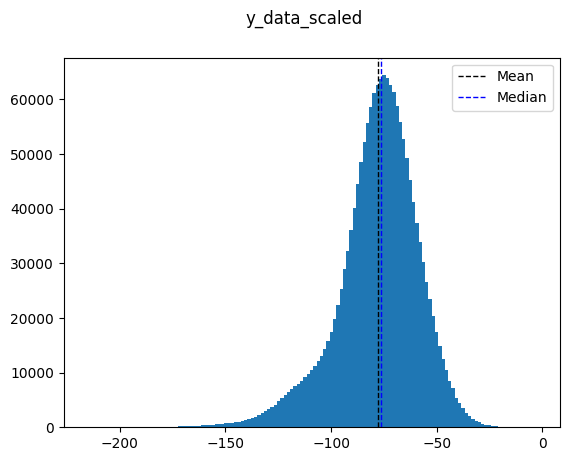

In [8]:
# Example usage
x_data, y_data = get_x_data_y_data(_rawData, 'fixed', 0)
plot_data_statistics(x_data,'x_data_scaled')
plot_data_statistics(y_data,'y_data_scaled')

# Scaling Data Using Different Scalers in Python

This code snippet demonstrates the use of different scaling techniques from the `sklearn.preprocessing` module to normalize or standardize data.


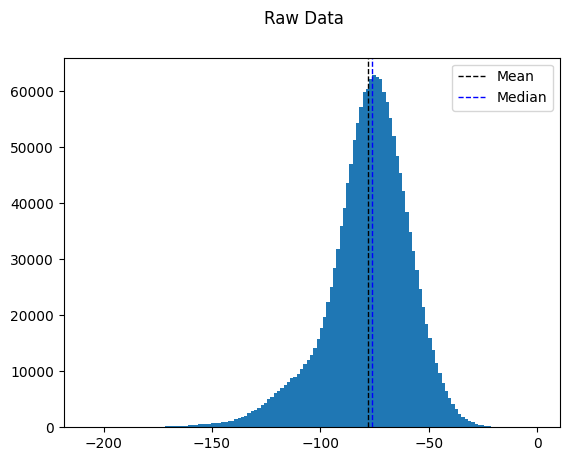

<class 'numpy.ndarray'>


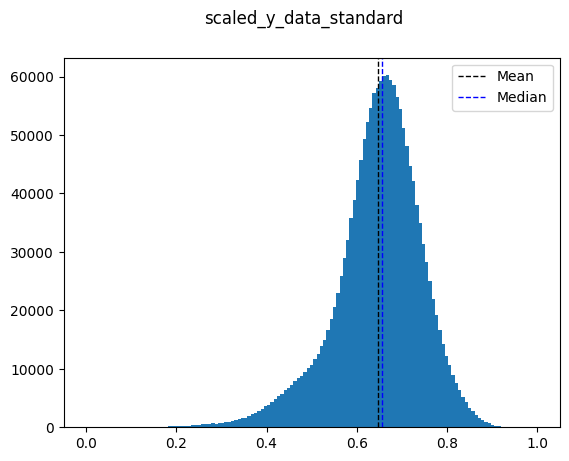

<class 'numpy.ndarray'>


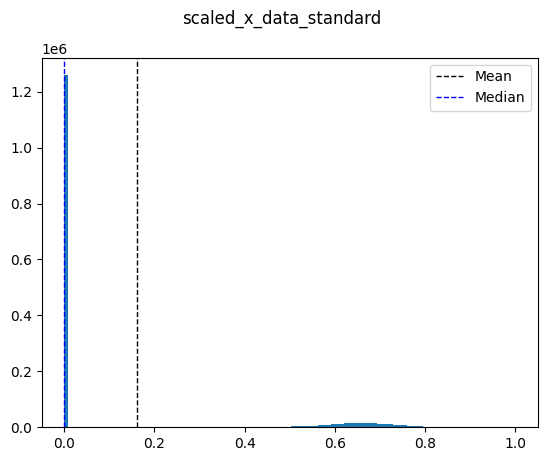

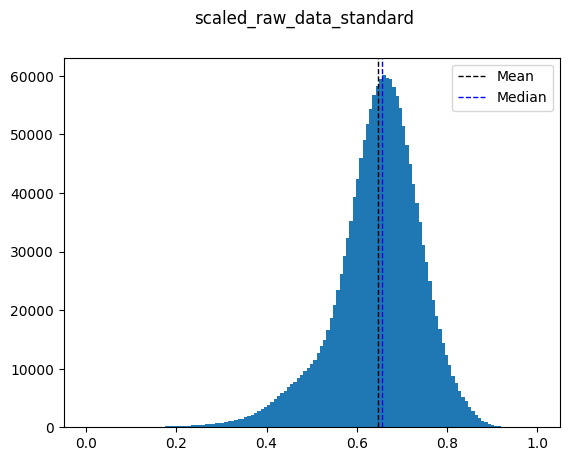

In [9]:
from sklearn.preprocessing import MinMaxScaler
def _getScaledData(data):
    """
    Scale the input data using the MinMaxScaler.

    This function creates an instance of MinMaxScaler, fits it to the input data,
    and then transforms the data. It scales the features to have a mean of 0 and a
    variance of 1, which is a standard practice for many machine learning algorithms
    to work effectively. The function returns the scaled data along with the scaler
    instance used. This scaler instance can be used later for inverse transformations
    or to apply the same scaling to new datasets.

    Parameters:
    data (array-like): The input data that needs to be scaled. This could be a list,
                       numpy array, or a pandas DataFrame.

    Returns:
    tuple: A tuple containing the scaled dataset and the scaler instance. The first
           element of the tuple is the scaled data, and the second element is the
           MinMaxScaler instance that was used for scaling.
    """
    # Create an instance of the MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler to the data. This computes the mean and standard deviation to be used for later scaling.
    scaler.fit(data)

    # Transform the data using the fitted scaler. This scales the data to a standard scale.
    scaledDataSet = scaler.transform(data)

    # Return the scaled data and the scaler instance.
    # This is useful if you need to inverse transform the scaled data later or apply the same transformation to new data.
    return scaledDataSet, scaler


plot_data_statistics(_rawData,'Raw Data')

scaled_y_data_standard, scaler_y_org = _getScaledData(y_data)
print(type(scaled_y_data_standard))
plot_data_statistics(scaled_y_data_standard,'scaled_y_data_standard')

scaled_x_data_standard, scaler_x_org = _getScaledData(x_data)
print(type(scaled_x_data_standard))
plot_data_statistics(scaled_x_data_standard,'scaled_x_data_standard')

scaled_raw_data_standard, scaler_raw_org = _getScaledData(_rawData)
plot_data_statistics(scaled_raw_data_standard,'scaled_raw_data_standard')

# Function for Saving and Downloading DataFrames as Excel Files

This Python code snippet saves data sets as Excel files and downloads them, including both the full data sets and selected entries from each data set.

In [11]:
# @author: jalal
# """

import pandas as pd
from google.colab import files

def save_and_download_dataframes(data_sets, file_names, num_entries):
    """
    Saves each data set in the data_sets list as an Excel file with specified file names and downloads them.
    Additionally, saves and downloads the first and last specified number of entries of each data set as separate Excel files.

    Args:
    data_sets (list of iterables): List of data sets to be saved and downloaded.
    file_names (list of str): List of file names for the full data sets.
    num_entries (int): Number of first and last entries to be saved and downloaded for each data set.
    """

    for i, data in enumerate(data_sets):
        # Create DataFrame from the provided data set
        df = pd.DataFrame(data)

        # Ensure the file names end with '.xlsx'
        first_last_file_name = f"{file_names[i].rstrip('.xlsx')}_first_AND_last_{num_entries}_samples.xlsx"

        # Extract the first and last 'num_entries' from the DataFrame
        first_last_entries = pd.concat([df.head(num_entries), df.tail(num_entries)])

        # Save the combined first and last entries to a separate Excel file
        first_last_entries.to_excel(first_last_file_name, index=False)

        # Download the Excel files
        files.download(first_last_file_name)

# Example usage of the function:
data_sets = [_rawData, x_data, scaled_x_data_standard, y_data, scaled_y_data_standard]
file_names = ['raw_data_actual_L1-RSRPs', 'x_data_rsrp', 'scaled_x_data_standard', 'y_data_rsrp', 'scaled_y_data_standard']
num_entries = 10
save_and_download_dataframes(data_sets, file_names, num_entries)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# KPIs


In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K

class CustomKPI:
    def custom_loss(self, ytrue, yhat):
        """
        Custom loss function that weighs the loss based on the frequency of each class in ytrue.
        """
        # Calculating weights for each class based on their frequency in ytrue
        weights = ytrue / K.sum(ytrue)
        # Normalizing yhat so that the class probabilities of each sample sum to 1
        yhat /= K.sum(yhat, axis=-1, keepdims=True)
        # Clipping yhat to prevent NaN's and Inf's
        yhat = K.clip(yhat, K.epsilon(), 1 - K.epsilon())
        # Calculating the weighted loss
        loss = ytrue * K.log(yhat) * 100 * weights
        loss = -K.sum(loss, -1)
        return loss

    def top_k_accuracies(self, y_hat, y_true, top_k):
        accuracies = {k: 0 for k in top_k}

        for predicted_vector, true_vector in zip(y_hat, y_true):
            for k in top_k:
                # Get top-k indices for both predicted and true vectors
                predicted_top_k = set(np.argsort(predicted_vector)[-k:])
                true_top_k = set(np.argsort(true_vector)[-k:])

                # Check for any overlap between the sets
                if len(predicted_top_k.intersection(true_top_k)) > 0:
                    accuracies[k] += 1

        return {k: accuracy / len(y_true) for k, accuracy in accuracies.items()}



    def _rsrpDiff(self, y_pred, y_true):
        """
        Simplified function to calculate the difference in RSRP (Reference Signal Received Power).
        """
        # Get the number of samples
        num_samples = y_pred.shape[0]

        # Define the k values for which to calculate differences
        k_values = [1, 2, 4, 6, 8]

        # Initialize a dictionary to store RSRP differences for each k value
        topRSRPdiffs = {k: np.zeros(num_samples) for k in k_values}

        # Iterate over each sample
        for s in range(num_samples):
            # Get the corresponding true maximum RSRP value
            true_max_RSRP = y_true[s, :].max()

            # Iterate over each k value
            for k in k_values:
                # Get the indices of the top k predictions for the current sample
                top_k_idxs = np.argsort(y_pred[s, :])[-k:][::-1]

                # Get the maximum RSRP value among the top k predictions
                top_k_max_RSRP = y_true[s, top_k_idxs].max()

                # Calculate and store the absolute difference between true max RSRP and top k max RSRP
                topRSRPdiffs[k][s] = abs(true_max_RSRP - top_k_max_RSRP)
        # print the best beam ID!!!
        print('true_max_RSRP',true_max_RSRP)
        # Return the mean of the RSRP differences for each k value
        return [np.mean(topRSRPdiffs[k]) for k in k_values]

    def _L1_rsrpDiffs(self, y_pred, y_true, k_values):
        """
        Function to calculate the difference in RSRP (Reference Signal Received Power) for multiple top k values.
        """
        # Initialize a dictionary to store RSRP differences for each k value
        topRSRPdiffs = {k: [] for k in k_values}

        # Iterate over each sample
        for s in range(y_pred.shape[0]):
            # Get the corresponding true maximum RSRP value
            true_max_RSRP = y_true[s, :].max()

            # Iterate over each k value
            for k in k_values:
                # Get the indices of the top k predictions for the current sample
                top_k_idxs = np.argsort(y_pred[s, :])[-k:][::-1]

                # Get the maximum RSRP value among the top k predictions
                top_k_max_RSRP = y_true[s, top_k_idxs].max()

                # Calculate and store the absolute difference between true max RSRP and top k max RSRP
                topRSRPdiffs[k].append(abs(true_max_RSRP - top_k_max_RSRP))

        # Return the mean of the RSRP differences for each k value
        return {k: np.mean(diffs) for k, diffs in topRSRPdiffs.items()}


    def _rsrpDiffNaiveBaseline(self, trueRSRPs, samplingPatternStr):
        """
        Function to calculate RSRP difference for a naive baseline method.
        """
        # Initialization
        nsamples, total_beams = trueRSRPs.shape
        topRSRPdiff = np.zeros(trueRSRPs.shape[0])
        topAccuracy = np.zeros(trueRSRPs.shape[0])

        if samplingPatternStr=='fixed':

            idxs = prepData.GetBPatternIdxs(total_beams, SET_B_LEN, prepData.PRESET_K_FOR_FIXED_BPATTERN)

            for s in range(trueRSRPs.shape[0]):
                ySweeped = trueRSRPs[s, idxs]
                topRSRPdiff[s] = abs(trueRSRPs[s,:].max() - ySweeped.max())

                if trueRSRPs[s,:].max()==ySweeped.max():
                    topAccuracy[s] = 1

        elif samplingPatternStr=='preset':
            K1= 16 if trueRSRPs.shape[1] == 256 else 8 if trueRSRPs.shape[1] == 32 else 32 if trueRSRPs.shape[1] == 64*8 else 8
            K2 = total_beams//K1 # = int(np.sqrt(total_beams))
            #k = int(np.sqrt(total_beams))
            allBeamIndices = np.arange(total_beams).reshape(K1, K2) #16, 16)
            totalPreset = 5
            presets = np.zeros((totalPreset, SET_B_LEN), dtype=int)
            for k in range(totalPreset):
                presets[k, :] = prepData.GetBPatternIdxs(total_beams, SET_B_LEN, k)
            for sample in range(trueRSRPs.shape[0]):
                idxs = presets[sample % totalPreset]
                ySweeped = trueRSRPs[sample, idxs]
                topRSRPdiff[sample] = abs(trueRSRPs[sample, :].max() - ySweeped.max())
                if trueRSRPs[sample, :].max() == ySweeped.max():
                    topAccuracy[sample] = 1

        elif samplingPatternStr=='random':
            for s in range(trueRSRPs.shape[0]):
                idxs = np.random.choice(total_beams, SET_B_LEN).astype(int)
                ySweeped = trueRSRPs[s, idxs]
                topRSRPdiff[s] = abs(trueRSRPs[s,:].max() - ySweeped.max())

                if trueRSRPs[s,:].max()==ySweeped.max():
                    topAccuracy[s] = 1

        return topRSRPdiff.mean(), topAccuracy.mean()

In [14]:
# Usage example:
print("The model custom loss is:", CustomKPI().custom_loss(scaled_y_data_standard, scaled_y_data_standard))
print("The Top-k (k=[1,2,4,8]) accurancies are:", CustomKPI().top_k_accuracies(scaled_y_data_standard, scaled_x_data_standard, [1,2,4,8]))
print("The RSRP difference is:",CustomKPI()._rsrpDiff(scaled_y_data_standard, scaled_x_data_standard))
print("The naive RSRP difference is:",CustomKPI()._rsrpDiffNaiveBaseline(y_data, 'fixed'))
print("Is my y_data the same is my raw data?",np.all(scaled_y_data_standard == scaled_raw_data_standard))
print("Is my y_data the same is x_data?",np.all(scaled_y_data_standard == scaled_x_data_standard))

The model custom loss is: tf.Tensor([0.00041745 0.00049366 0.00017353 ... 0.00050402 0.0005514  0.00012076], shape=(524288,), dtype=float64)
The Top-k (k=[1,2,4,8]) accurancies are: {1: 0.21852684020996094, 2: 0.3579597473144531, 4: 0.5900382995605469, 8: 0.8606204986572266}
true_max_RSRP 0.4406887347692775
The RSRP difference is: [0.5482358698916323, 0.4489982156817906, 0.2847460928709124, 0.16618984529185504, 0.09506695778750245]
The naive RSRP difference is: (6.245991220563758, 0.24419784545898438)
Is my y_data the same is my raw data? True
Is my y_data the same is x_data? False


 ==> after reshape: 
     -> xDataTrain,xScaledData ==> xTrainData=(424673, 32, 1), xDataVal==> xValData=(47186, 32, 1), xTestData=(52429, 32, 1)


 ==> after reshape: 
     -> yDataTrain,yScaledData ==> yTrainData=(424673, 32, 1), yDataVal==> yValData=(47186, 32, 1), yTestData=(52429, 32, 1)


Indices: [2, 3, 5, 10, 11, 17, 19, 31]
yTrainData:


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.406902,0.392012,0.390028,0.457215,0.401168,0.386982,0.450856,0.430801,0.436325,0.387880,...,0.411647,0.437074,0.399029,0.378055,0.483082,0.452112,0.405860,0.403140,0.440933,0.484721
1,0.777527,0.711429,0.645584,0.685337,0.789529,0.687604,0.648294,0.708204,0.771874,0.689922,...,0.644622,0.732900,0.815446,0.739966,0.691955,0.715568,0.736122,0.669998,0.651836,0.651237
2,0.711286,0.681307,0.752972,0.684181,0.666503,0.661112,0.704636,0.668516,0.733276,0.701697,...,0.721700,0.712694,0.687341,0.669075,0.743057,0.667719,0.710833,0.691024,0.790427,0.683787
3,0.599443,0.656779,0.652438,0.689942,0.735209,0.684422,0.667135,0.786497,0.648669,0.604740,...,0.631862,0.720130,0.701764,0.654651,0.662740,0.749254,0.604362,0.624862,0.657597,0.662135
4,0.638695,0.594968,0.636943,0.707400,0.634925,0.736688,0.769632,0.842367,0.614178,0.549434,...,0.706250,0.755031,0.570652,0.664444,0.702813,0.766688,0.727392,0.662770,0.757457,0.805198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424668,0.772937,0.701956,0.600883,0.683433,0.824450,0.759644,0.693519,0.686911,0.726741,0.671068,...,0.566615,0.650046,0.802510,0.738192,0.675667,0.657159,0.684970,0.630829,0.571534,0.602619
424669,0.682404,0.692280,0.667273,0.624564,0.654651,0.664439,0.613516,0.631959,0.695639,0.672653,...,0.619481,0.648907,0.617844,0.643519,0.630881,0.620515,0.669455,0.683276,0.686585,0.590760
424670,0.632162,0.737093,0.711464,0.671408,0.631695,0.680436,0.646090,0.609568,0.650943,0.677125,...,0.685677,0.681701,0.617377,0.665863,0.646974,0.606469,0.634668,0.720018,0.694595,0.642989
424671,0.672567,0.690898,0.696021,0.768375,0.643788,0.622659,0.654690,0.674555,0.640582,0.610347,...,0.670599,0.721592,0.642292,0.628853,0.674823,0.638445,0.644152,0.671320,0.706751,0.745216


xTrainData:


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.390028,0.457215,0.0,0.386982,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.484721
1,0.0,0.0,0.645584,0.685337,0.0,0.687604,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651237
2,0.0,0.0,0.752972,0.684181,0.0,0.661112,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.683787
3,0.0,0.0,0.652438,0.689942,0.0,0.684422,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.662135
4,0.0,0.0,0.636943,0.707400,0.0,0.736688,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.805198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424668,0.0,0.0,0.600883,0.683433,0.0,0.759644,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.602619
424669,0.0,0.0,0.667273,0.624564,0.0,0.664439,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.590760
424670,0.0,0.0,0.711464,0.671408,0.0,0.680436,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.642989
424671,0.0,0.0,0.696021,0.768375,0.0,0.622659,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.745216


xTest:


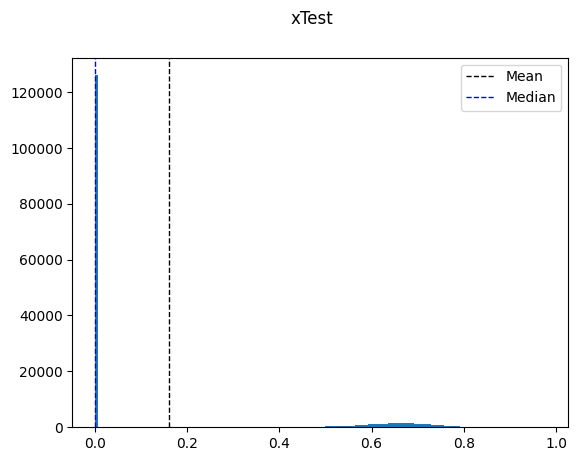

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.672990,0.757724,0.0,0.733961,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.757082
1,0.0,0.0,0.585479,0.531645,0.0,0.619044,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.518198
2,0.0,0.0,0.623519,0.608375,0.0,0.584744,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.580232
3,0.0,0.0,0.477308,0.452107,0.0,0.550653,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441705
4,0.0,0.0,0.635936,0.718918,0.0,0.673960,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.694717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52424,0.0,0.0,0.572783,0.522857,0.0,0.609314,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.504837
52425,0.0,0.0,0.692145,0.669218,0.0,0.670203,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.668074
52426,0.0,0.0,0.710077,0.598233,0.0,0.704481,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.628872
52427,0.0,0.0,0.747086,0.707230,0.0,0.738122,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758396


Is my yTrainData the same is my xTrainData? False
Is my yDataTrain the same is my xDataTrain? False


In [19]:
from sklearn.model_selection import train_test_split as trsplit
usePreviousTrainTest = False
total_beams = _rawData.shape[1]
K1= _rawData.shape[1]

randDrawPerSample = 1
totalSamples = int(_rawData.shape[0]*randDrawPerSample)
trainTestRatio = 0.9
trainDataLen = int(_rawData.shape[0] * trainTestRatio)
trainValSplitRatio = 0.10
xDataTrain, xDataVal, yDataTrain, yDataVal = trsplit(x_data[:trainDataLen], y_data[:trainDataLen], test_size=trainValSplitRatio,shuffle=True)

xScaledData, scaler_xDataTrain = _getScaledData(xDataTrain)
# print(scaler_xDataTrain)
xTrainData = xScaledData.reshape(len(xScaledData), K1, 1)
xValData = scaler_xDataTrain.transform(xDataVal).reshape(len(xDataVal), K1, 1)
# x_test, scaler_xData = _getScaledData(x_data[trainDataLen:, :])
xTestData = scaler_xDataTrain.transform(x_data[trainDataLen:, :]).reshape(totalSamples - trainDataLen, K1, 1)

print(" ==> after reshape: \n     -> xDataTrain,xScaledData ==> xTrainData=%s, xDataVal==> xValData=%s, xTestData=%s\n\n" %
 (xTrainData.shape, xValData.shape, xTestData.shape))



yScaledData, scaler_yDataTrain = _getScaledData(yDataTrain)
# print(scaler_yDataTrain)
yTrainData = yScaledData.reshape(len(yScaledData), K1, 1)
yValData = scaler_yDataTrain.transform(yDataVal).reshape(len(yDataVal), K1, 1)
# y_test, scaler_yData = _getScaledData(y_data[trainDataLen:, :])
yTestData = scaler_yDataTrain.transform(y_data[trainDataLen:, :]).reshape(totalSamples - trainDataLen, K1, 1)

print(" ==> after reshape: \n     -> yDataTrain,yScaledData ==> yTrainData=%s, yDataVal==> yValData=%s, yTestData=%s\n\n" %
 (yTrainData.shape, yValData.shape, yTestData.shape))

# yTestData = y_data[trainDataLen:, :]
dataLen = len(_rawData)
trainLen = len(xTrainData)

xTrain, yTrain, xVal, yVal, xTest, yTest, trainedScaler, yTestRSRPs = xTrainData, yTrainData, xValData, yValData, xTestData, yTestData, scaler_yDataTrain, _rawData[trainDataLen:,:]

print('Indices: [2, 3, 5, 10, 11, 17, 19, 31]')

print('yTrainData:')
display(pd.DataFrame(yTrainData.reshape(len(yTrainData), 32)))
print('xTrainData:')
display(pd.DataFrame(xTrainData.reshape(len(xTrainData), 32)))

print('xTest:')
plot_data_statistics(xTest,'xTest')
display(pd.DataFrame(xTest.reshape(len(xTest), 32)))

print("Is my yTrainData the same is my xTrainData?",np.all(yTrainData == xTrainData))
print("Is my yDataTrain the same is my xDataTrain?",np.all(xDataTrain == yDataTrain))

In [21]:
# Add the Directory to sys.path:
# This step is necessary to allow Python to find your models.py file.
sys.path.append('/content/drive/MyDrive/regression_problem')

# Import the getModel Class:
# Now, you can import the getModel class from your models.py file.
from models import getModel


totalBeams = _rawData.shape[1]
ipCh = 1
ipFilter = 32
kerWid = 3
kerLen = 3
fcLayer1s = 1024
fcLayer2s = 512
ipLength = 32
ipWidth = 1
modelNameString ='fcJalal'
modelClassIns = getModel(_opDim=_rawData.shape[1])

def _getModel():
    print(' --> inside getModel, parser.modelNameString=%s' % modelNameString)
    if modelNameString=='cnn':
        model = modelClassIns.getCnnModel(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                                _inputFilter=ipFilter, _kerLen=kerLen,
                                                _kerWid=kerWid)

    elif modelNameString=='fc':
        model = modelClassIns.getFCModel(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                         fcLayer1s=fcLayer1s,fcLayer2s=fcLayer2s)

    # What is the ceiling of the performance for the FC model architecture
    elif modelNameString=='fc_ceiling':
        model = modelClassIns.getFCModel_ceiling(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                                 fcLayer1s=fcLayer1s,fcLayer2s=fcLayer2s)

    elif modelNameString=='fcJalal':
        model = modelClassIns.getFCModelJalal1(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                               fcLayer1s=fcLayer1s,fcLayer2s=fcLayer2s)

    # What is the ceiling of the performance for the simplest model architecture
    elif modelNameString=='fcJalal1_ceiling':
        model = modelClassIns.getFCModelJalal1_ceiling(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                                       fcLayer1s=fcLayer1s,fcLayer2s=fcLayer2s)

    #add Batch Normalization (BN)
    elif modelNameString=='fcJalal2':
        model = modelClassIns.getFCModelJalal2(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                               fcLayer1s=fcLayer1s,fcLayer2s=fcLayer2s)

    # increasing # of layers
    elif modelNameString=='fcJalal3':
        model = modelClassIns.getFCModelJalal3(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                               fcLayer1s=fcLayer1s,fcLayer2s=fcLayer2s)

    # What is the ceiling of the performance for the best model architecture
    elif modelNameString=='fcJalal3_ceiling':
        model = modelClassIns.getFCModelJalal3_ceiling(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                                       fcLayer1s=fcLayer1s,fcLayer2s=fcLayer2s)

    #increasing # of neurons
    elif modelNameString=='fcJalal4':
        model = modelClassIns.getFCModelJalal4(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                               fcLayer1s=fcLayer1s, fcLayer2s=fcLayer2s)

    # with leakyRelu
    elif modelNameString=='fcJalal5':
        model = modelClassIns.getFCModelJalal5(ipCh=ipCh, ipLen=ipLength, ipWid=ipWidth,
                                               fcLayer1s=fcLayer1s,fcLayer2s=fcLayer2s)

    # print("Model Summary", model.summary())

    return model

model = _getModel()
custom_KPI = CustomKPI()

# yhat = model.predict(xTrain)

 --> inside getModel, parser.modelNameString=fcJalal


In [25]:
# o	Prediction input: raw, scaled, direct input to the model
print('xTrain')
display(pd.DataFrame(xTrain.reshape(len(xTrain), 32)))
print('yTrain')
display(pd.DataFrame(yTrain.reshape(len(yTrain), 32)))
print('xVal')
display(pd.DataFrame(xVal.reshape(len(yVal), 32)))
print('yVal')
display(pd.DataFrame(yVal.reshape(len(yVal), 32)))

xTrain


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.390028,0.457215,0.0,0.386982,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.484721
1,0.0,0.0,0.645584,0.685337,0.0,0.687604,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651237
2,0.0,0.0,0.752972,0.684181,0.0,0.661112,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.683787
3,0.0,0.0,0.652438,0.689942,0.0,0.684422,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.662135
4,0.0,0.0,0.636943,0.707400,0.0,0.736688,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.805198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424668,0.0,0.0,0.600883,0.683433,0.0,0.759644,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.602619
424669,0.0,0.0,0.667273,0.624564,0.0,0.664439,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.590760
424670,0.0,0.0,0.711464,0.671408,0.0,0.680436,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.642989
424671,0.0,0.0,0.696021,0.768375,0.0,0.622659,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.745216


yTrain


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.406902,0.392012,0.390028,0.457215,0.401168,0.386982,0.450856,0.430801,0.436325,0.387880,...,0.411647,0.437074,0.399029,0.378055,0.483082,0.452112,0.405860,0.403140,0.440933,0.484721
1,0.777527,0.711429,0.645584,0.685337,0.789529,0.687604,0.648294,0.708204,0.771874,0.689922,...,0.644622,0.732900,0.815446,0.739966,0.691955,0.715568,0.736122,0.669998,0.651836,0.651237
2,0.711286,0.681307,0.752972,0.684181,0.666503,0.661112,0.704636,0.668516,0.733276,0.701697,...,0.721700,0.712694,0.687341,0.669075,0.743057,0.667719,0.710833,0.691024,0.790427,0.683787
3,0.599443,0.656779,0.652438,0.689942,0.735209,0.684422,0.667135,0.786497,0.648669,0.604740,...,0.631862,0.720130,0.701764,0.654651,0.662740,0.749254,0.604362,0.624862,0.657597,0.662135
4,0.638695,0.594968,0.636943,0.707400,0.634925,0.736688,0.769632,0.842367,0.614178,0.549434,...,0.706250,0.755031,0.570652,0.664444,0.702813,0.766688,0.727392,0.662770,0.757457,0.805198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424668,0.772937,0.701956,0.600883,0.683433,0.824450,0.759644,0.693519,0.686911,0.726741,0.671068,...,0.566615,0.650046,0.802510,0.738192,0.675667,0.657159,0.684970,0.630829,0.571534,0.602619
424669,0.682404,0.692280,0.667273,0.624564,0.654651,0.664439,0.613516,0.631959,0.695639,0.672653,...,0.619481,0.648907,0.617844,0.643519,0.630881,0.620515,0.669455,0.683276,0.686585,0.590760
424670,0.632162,0.737093,0.711464,0.671408,0.631695,0.680436,0.646090,0.609568,0.650943,0.677125,...,0.685677,0.681701,0.617377,0.665863,0.646974,0.606469,0.634668,0.720018,0.694595,0.642989
424671,0.672567,0.690898,0.696021,0.768375,0.643788,0.622659,0.654690,0.674555,0.640582,0.610347,...,0.670599,0.721592,0.642292,0.628853,0.674823,0.638445,0.644152,0.671320,0.706751,0.745216


xVal


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.689451,0.754834,0.0,0.603231,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.764392
1,0.0,0.0,0.612186,0.621414,0.0,0.619122,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.628266
2,0.0,0.0,0.754830,0.674236,0.0,0.741145,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622590
3,0.0,0.0,0.701725,0.617859,0.0,0.580227,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.610846
4,0.0,0.0,0.744177,0.758867,0.0,0.614804,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.741831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47181,0.0,0.0,0.531791,0.534323,0.0,0.487540,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.526410
47182,0.0,0.0,0.695377,0.703931,0.0,0.698951,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640210
47183,0.0,0.0,0.776749,0.848687,0.0,0.694070,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.762720
47184,0.0,0.0,0.599946,0.649415,0.0,0.788975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.602839


yVal


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.683421,0.663505,0.689451,0.754834,0.649772,0.603231,0.616968,0.665190,0.728015,0.642946,...,0.635176,0.713678,0.662707,0.609690,0.628564,0.682903,0.682409,0.652133,0.716488,0.764392
1,0.681910,0.677110,0.612186,0.621414,0.670194,0.619122,0.562335,0.591382,0.716213,0.695159,...,0.550426,0.642725,0.692542,0.642891,0.574664,0.603442,0.636962,0.689559,0.600884,0.628266
2,0.691839,0.709186,0.754830,0.674236,0.727468,0.741145,0.782562,0.743234,0.723423,0.682205,...,0.662950,0.673820,0.716799,0.733944,0.775438,0.727316,0.646189,0.667120,0.724240,0.622590
3,0.644631,0.644718,0.701725,0.617859,0.575283,0.580227,0.617248,0.575170,0.609573,0.591356,...,0.654734,0.638846,0.554665,0.576133,0.616568,0.577170,0.617925,0.642227,0.688729,0.610846
4,0.672891,0.695126,0.744177,0.758867,0.654293,0.614804,0.683107,0.646131,0.674243,0.617127,...,0.725220,0.729704,0.638460,0.620610,0.671673,0.630659,0.654017,0.674432,0.753149,0.741831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47181,0.492625,0.487544,0.531791,0.534323,0.522712,0.487540,0.580178,0.551118,0.498992,0.465855,...,0.533855,0.518959,0.505254,0.482280,0.566937,0.522734,0.479487,0.459935,0.518799,0.526410
47182,0.727507,0.792243,0.695377,0.703931,0.694295,0.698951,0.593872,0.626429,0.716263,0.736978,...,0.664085,0.737904,0.698466,0.755249,0.627011,0.633216,0.638969,0.668260,0.685044,0.640210
47183,0.774935,0.785789,0.776749,0.848687,0.731481,0.694070,0.645255,0.666922,0.790775,0.731123,...,0.846252,0.866291,0.775697,0.757032,0.788441,0.761341,0.705581,0.719483,0.717602,0.762720
47184,0.613846,0.724927,0.599946,0.649415,0.742537,0.788975,0.640426,0.612112,0.624821,0.726597,...,0.578987,0.646655,0.732746,0.782378,0.636849,0.593905,0.579813,0.677074,0.574520,0.602839


In [22]:
# sample test

epoch = 10
batchSize = 512
chkpointFname = '/content/drive/MyDrive/regression_problem/chkpoint'

trainDatasetTFint = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
valDatasetTFint = tf.data.Dataset.from_tensor_slices((xVal, yVal))

trainDatasetTF = trainDatasetTFint.batch(batchSize)
valDatasetTF = valDatasetTFint.batch(batchSize)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpointFname,
    save_weights_only=False, verbose=2,  # save_weights_only=True
    monitor='val_accuracy', mode='max',
    save_best_only=True)

model = _getModel()
model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.MeanSquaredError(),
                             tf.keras.metrics.MeanAbsoluteError()])


print('\n\n -> before calling history, batch_size=%d\n\n' % batchSize)

history = model.fit(trainDatasetTF, epochs=epoch, validation_data=valDatasetTF,
                          batch_size=batchSize)

 --> inside getModel, parser.modelNameString=fcJalal


 -> before calling history, batch_size=512


Epoch 1/10
830/830 [==============================] - 6s 4ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0463 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0227
Epoch 2/10
830/830 [==============================] - 3s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0302 - val_loss: 9.0605e-04 - val_mean_squared_error: 9.0605e-04 - val_mean_absolute_error: 0.0217
Epoch 3/10
830/830 [==============================] - 3s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0264 - val_loss: 7.3279e-04 - val_mean_squared_error: 7.3279e-04 - val_mean_absolute_error: 0.0187
Epoch 4/10
830/830 [==============================] - 3s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0239 - val_loss: 6.4617e-04 - val_mean_squared_error: 6.4617e-04 - val_

In [23]:
import numpy as np
import pandas as pd

def add_best_beam_column(array):
    """
    Computes the argmax (index of the maximum value) for each row of the array,
    and adds it as a new column named 'best_beam' to the DataFrame.

    Args:
    array (numpy.ndarray): The array to which the 'best_beam' column will be added.

    Returns:
    pandas.DataFrame: DataFrame with the added 'best_beam' column.
    """
    best_beam = np.argmax(array, axis=1)
    df = pd.DataFrame(array)
    df['best_beam'] = best_beam
    return df

### prediction ###
yhat = model.predict(xTest)
yhat_desclaed  = scaler_raw_org.inverse_transform(yhat)

yhat_with_best_beam_ID = add_best_beam_column(yhat)
yhat_desclaed_with_best_beam_ID = add_best_beam_column(yhat_desclaed)
################################################################################
################################################################################
################################################################################


### expected ###
yTest = yTest.reshape(len(yTest), 32)
yTest_desclaed = scaler_y_org.inverse_transform(yTest)

yTest_with_best_beam_ID = add_best_beam_column(yTest)
yTest_desclaed_with_best_beam_ID = add_best_beam_column(yTest_desclaed)
################################################################################
################################################################################
################################################################################

data_sets = [xTest.reshape(len(yTest), 32),
             yTest_with_best_beam_ID,
             yTest_desclaed_with_best_beam_ID,
             yhat_with_best_beam_ID,
             yhat_desclaed_with_best_beam_ID]
file_names = ['xTest_model_input',
              'yTest_expected_output',
              'yTest_expected_descaled_output',
              'yhat_prediction_output',
              'yhat_prediction_descaled_output']
num_entries = 10
save_and_download_dataframes(data_sets, file_names, num_entries)

custom_KPI.top_k_accuracies(yhat, yTest, top_k=[1,2,4,8])

yhat_desclaed
display(pd.DataFrame(yhat_desclaed))


1639/1639 [==============================] - 2s 1ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-73.759132,-70.356781,-71.348427,-57.827824,-52.884880,-60.673538,-64.963310,-53.201313,-80.622658,-84.596825,...,-63.204018,-57.142239,-67.710869,-71.614723,-76.373024,-66.549049,-75.274628,-65.226112,-70.779839,-57.394985
1,-87.240303,-88.269371,-90.448570,-100.477242,-85.945274,-81.327667,-89.613808,-88.326118,-93.258743,-91.021446,...,-98.545876,-98.447884,-90.269936,-84.337486,-93.393135,-92.402290,-92.555397,-88.168800,-95.743973,-103.297607
2,-78.161964,-82.139313,-80.860580,-85.763374,-78.548416,-87.767166,-85.649773,-84.181229,-84.540520,-90.089478,...,-88.611588,-86.913986,-83.287193,-89.154831,-89.125572,-88.291031,-84.831543,-83.170570,-85.863647,-90.370888
3,-112.722305,-103.117699,-110.969032,-116.696175,-108.435555,-94.227776,-105.639740,-109.465240,-115.384224,-106.986931,...,-112.759827,-116.884727,-110.928474,-96.106712,-107.266174,-111.795860,-115.523293,-102.114395,-112.583992,-118.619003
4,-77.687965,-86.679840,-77.035896,-63.908966,-76.518509,-73.519577,-70.862404,-62.142666,-74.402962,-78.489166,...,-77.946350,-76.839233,-77.542068,-72.688660,-71.544533,-63.584763,-84.621758,-87.564919,-80.625343,-69.467247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52424,-100.181030,-94.967751,-92.441559,-103.905540,-96.787209,-84.623634,-87.062279,-95.676407,-101.963753,-95.796043,...,-95.909012,-104.229362,-100.092018,-86.723083,-89.325684,-98.874657,-104.092003,-94.020576,-94.580528,-105.903656
52425,-62.005577,-69.308548,-67.532707,-73.834259,-49.747471,-72.944809,-64.530884,-57.348843,-67.135078,-77.420677,...,-77.007187,-73.838257,-64.204613,-80.847214,-76.469154,-71.935883,-62.660923,-64.436829,-66.008080,-73.033150
52426,-77.808235,-83.271957,-62.782448,-90.099083,-73.783562,-65.643471,-39.352760,-54.861713,-79.899506,-82.265198,...,-51.410633,-79.195869,-88.180817,-79.729927,-55.579609,-71.534668,-73.361931,-72.504707,-55.494526,-81.097664
52427,-76.945435,-73.163429,-57.108143,-67.197266,-53.742378,-58.976597,-40.658016,-55.933849,-75.859291,-79.223839,...,-45.504452,-58.273144,-72.473053,-73.120529,-57.341412,-72.774063,-69.129295,-58.515965,-47.225040,-55.462997


In [27]:
# o	Prediction output: direct output from the model, descaled (if needed for KPI calculation, e.g., for L1-RSRP difference)
print('yTest')
display(pd.DataFrame(yTest))
print('yTest_descaled')
display(pd.DataFrame(yTest_desclaed))

yhat = model.predict(xTest)
print('yhat')
display(pd.DataFrame(yhat))

print('yTest_rescaled')
yTest_rescaled = scaler_raw_org.inverse_transform(yTest)
display(pd.DataFrame(yTest_rescaled))

yTest


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.686174,0.659283,0.672990,0.757724,0.781947,0.733961,0.711599,0.834988,0.702218,0.621929,...,0.702033,0.821130,0.717988,0.671221,0.668371,0.769059,0.651031,0.689358,0.678273,0.757082
1,0.571073,0.606441,0.585479,0.531645,0.553308,0.619044,0.571520,0.600097,0.597011,0.572288,...,0.544823,0.579339,0.587987,0.622852,0.585500,0.600365,0.584685,0.600568,0.570407,0.518198
2,0.686819,0.603198,0.623519,0.608375,0.666045,0.584744,0.571788,0.604648,0.689137,0.570342,...,0.571367,0.644250,0.682603,0.572565,0.589103,0.604318,0.610367,0.573647,0.584006,0.580232
3,0.506711,0.559569,0.477308,0.452107,0.478545,0.550653,0.450409,0.470583,0.491071,0.507257,...,0.441677,0.477570,0.466048,0.538756,0.455190,0.448945,0.484731,0.529778,0.488029,0.441705
4,0.650697,0.581288,0.635936,0.718918,0.684242,0.673960,0.686614,0.766468,0.702049,0.624656,...,0.607326,0.681503,0.680123,0.671636,0.689275,0.760339,0.624677,0.551458,0.634883,0.694717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52424,0.569612,0.531163,0.572783,0.522857,0.579275,0.609314,0.521238,0.536128,0.567228,0.556823,...,0.520851,0.521320,0.562041,0.590817,0.549696,0.513546,0.530858,0.526044,0.590431,0.504837
52425,0.768320,0.693999,0.692145,0.669218,0.828176,0.670203,0.678047,0.750663,0.809707,0.674733,...,0.627805,0.696802,0.781420,0.644406,0.636930,0.697035,0.759061,0.689050,0.716906,0.668074
52426,0.660911,0.617742,0.710077,0.598233,0.669362,0.704481,0.808421,0.771272,0.674006,0.613141,...,0.758739,0.660842,0.613995,0.650751,0.759604,0.712760,0.685564,0.642218,0.766214,0.628872
52427,0.674250,0.701779,0.747086,0.707230,0.779679,0.738122,0.748297,0.832653,0.724575,0.667304,...,0.716760,0.818107,0.717187,0.684747,0.738149,0.759024,0.675842,0.699550,0.761359,0.758396


yTest_descaled


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-70.078119,-75.935155,-69.698873,-54.367540,-52.417797,-58.520976,-58.541122,-39.489093,-71.820250,-79.736607,...,-59.872680,-49.056662,-66.712194,-69.897150,-68.800250,-53.441182,-78.170053,-64.400762,-72.399849,-54.767686
1,-94.528134,-87.224453,-87.550821,-100.054168,-98.280999,-81.107658,-86.225724,-85.697698,-93.302664,-90.032255,...,-91.415101,-95.699556,-92.250549,-79.368513,-85.496298,-85.578337,-92.545703,-83.355971,-94.104562,-103.392887
2,-69.941148,-87.917272,-79.790765,-84.548404,-75.666735,-87.849301,-86.172690,-84.802426,-74.491461,-90.435906,...,-86.089380,-83.177785,-73.663516,-89.215600,-84.770287,-84.825196,-86.980948,-89.103042,-91.368173,-90.765721
3,-108.200065,-97.238039,-109.617204,-116.127450,-113.277686,-94.549859,-110.161527,-111.176341,-114.934822,-103.519804,...,-112.110210,-115.331342,-116.205232,-95.836118,-111.749844,-114.424644,-114.203711,-98.468337,-110.680475,-118.963308
4,-77.614163,-92.598169,-77.257799,-62.209566,-72.016704,-70.314167,-63.479070,-52.968567,-71.854833,-79.170938,...,-78.874532,-75.991419,-74.150629,-69.815735,-64.588574,-55.102492,-83.880394,-93.840158,-81.130807,-67.462126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52424,-94.838484,-103.306818,-90.140719,-101.830118,-93.072212,-83.020175,-96.163157,-98.282060,-99.384114,-93.239713,...,-96.224927,-106.891672,-97.347730,-85.641521,-92.709687,-102.117710,-104.208950,-99.265638,-90.075374,-106.112644
52425,-52.628598,-68.518402,-65.791425,-72.253242,-43.144683,-71.052591,-65.172268,-56.077779,-49.872111,-68.784902,...,-74.765648,-73.040134,-54.251176,-75.147958,-75.134509,-67.162258,-54.762101,-64.466520,-64.626148,-72.885516
52426,-75.444533,-84.810088,-62.133281,-86.597873,-75.001403,-64.315165,-39.405734,-52.023641,-77.581069,-81.559306,...,-48.495157,-79.977009,-87.141424,-73.905544,-50.419425,-64.166387,-70.687349,-74.464245,-54.704609,-80.865053
52427,-72.611100,-66.856433,-54.583709,-64.571581,-52.872744,-57.703096,-51.288291,-39.948491,-67.255217,-70.325537,...,-56.917793,-49.639721,-66.869561,-67.248489,-54.742004,-55.352928,-72.793990,-62.224932,-55.681433,-54.500185


1639/1639 [==============================] - 2s 1ms/step
yhat


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.668845,0.685394,0.664904,0.740601,0.779619,0.723009,0.679104,0.765285,0.659110,0.598495,...,0.685429,0.779215,0.712905,0.662449,0.630783,0.700253,0.664393,0.685492,0.686324,0.744175
1,0.605381,0.601550,0.571274,0.529552,0.614804,0.617925,0.554377,0.586736,0.597226,0.567518,...,0.509283,0.565092,0.598069,0.597477,0.546304,0.564545,0.584641,0.578023,0.562259,0.518666
2,0.648119,0.630243,0.618275,0.602363,0.651679,0.585162,0.574434,0.607806,0.639923,0.572012,...,0.558796,0.624882,0.633615,0.572876,0.567486,0.586125,0.620287,0.601436,0.611362,0.582172
3,0.485422,0.532048,0.470682,0.449293,0.502685,0.552291,0.473288,0.479281,0.488870,0.490540,...,0.438440,0.469517,0.492909,0.537374,0.477445,0.462744,0.478641,0.512699,0.478569,0.443396
4,0.650350,0.608990,0.637024,0.710509,0.661799,0.657651,0.649256,0.719834,0.689570,0.627943,...,0.611952,0.677108,0.662860,0.656965,0.654749,0.715814,0.621255,0.580852,0.637395,0.684867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52424,0.544462,0.570196,0.561504,0.512587,0.560754,0.601155,0.567287,0.549373,0.554595,0.544498,...,0.522425,0.535121,0.548071,0.585294,0.566492,0.530570,0.531398,0.550613,0.568041,0.505863
52425,0.724176,0.690301,0.683609,0.661394,0.795259,0.660575,0.681292,0.744202,0.725163,0.633095,...,0.616633,0.692665,0.730753,0.615301,0.630306,0.671977,0.722607,0.689189,0.710039,0.667348
52426,0.649784,0.624941,0.706895,0.580908,0.675433,0.697723,0.808689,0.756845,0.662651,0.609737,...,0.744208,0.664892,0.608704,0.621007,0.733991,0.674083,0.673221,0.651397,0.762288,0.627729
52427,0.653846,0.672257,0.734711,0.694237,0.775344,0.731643,0.802085,0.751395,0.682438,0.624401,...,0.773645,0.773353,0.688663,0.654760,0.725247,0.667577,0.692755,0.716923,0.803385,0.753666


yTest_rescaled


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-70.078119,-75.935155,-69.698873,-54.367540,-52.417797,-58.520976,-58.541122,-39.489093,-71.820250,-79.736607,...,-59.872680,-49.056662,-66.712194,-69.897150,-68.800250,-53.441182,-78.170053,-64.400762,-72.399849,-54.767686
1,-94.528134,-87.224453,-87.550821,-100.054168,-98.280999,-81.107658,-86.225724,-85.697698,-93.302664,-90.032255,...,-91.415101,-95.699556,-92.250549,-79.368513,-85.496298,-85.578337,-92.545703,-83.355971,-94.104562,-103.392887
2,-69.941148,-87.917272,-79.790765,-84.548404,-75.666735,-87.849301,-86.172690,-84.802426,-74.491461,-90.435906,...,-86.089380,-83.177785,-73.663516,-89.215600,-84.770287,-84.825196,-86.980948,-89.103042,-91.368173,-90.765721
3,-108.200065,-97.238039,-109.617204,-116.127450,-113.277686,-94.549859,-110.161527,-111.176341,-114.934822,-103.519804,...,-112.110210,-115.331342,-116.205232,-95.836118,-111.749844,-114.424644,-114.203711,-98.468337,-110.680475,-118.963308
4,-77.614163,-92.598169,-77.257799,-62.209566,-72.016704,-70.314167,-63.479070,-52.968567,-71.854833,-79.170938,...,-78.874532,-75.991419,-74.150629,-69.815735,-64.588574,-55.102492,-83.880394,-93.840158,-81.130807,-67.462126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52424,-94.838484,-103.306818,-90.140719,-101.830118,-93.072212,-83.020175,-96.163157,-98.282060,-99.384114,-93.239713,...,-96.224927,-106.891672,-97.347730,-85.641521,-92.709687,-102.117710,-104.208950,-99.265638,-90.075374,-106.112644
52425,-52.628598,-68.518402,-65.791425,-72.253242,-43.144683,-71.052591,-65.172268,-56.077779,-49.872111,-68.784902,...,-74.765648,-73.040134,-54.251176,-75.147958,-75.134509,-67.162258,-54.762101,-64.466520,-64.626148,-72.885516
52426,-75.444533,-84.810088,-62.133281,-86.597873,-75.001403,-64.315165,-39.405734,-52.023641,-77.581069,-81.559306,...,-48.495157,-79.977009,-87.141424,-73.905544,-50.419425,-64.166387,-70.687349,-74.464245,-54.704609,-80.865053
52427,-72.611100,-66.856433,-54.583709,-64.571581,-52.872744,-57.703096,-51.288291,-39.948491,-67.255217,-70.325537,...,-56.917793,-49.639721,-66.869561,-67.248489,-54.742004,-55.352928,-72.793990,-62.224932,-55.681433,-54.500185


In [ ]:
import pandas as pd
import tensorflow as tf
from datetime import datetime
import os


batchSize = 512
chkpointFname = '/content/drive/MyDrive/regression_problem/chkpoint'

trainDatasetTFint = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))
valDatasetTFint = tf.data.Dataset.from_tensor_slices((xVal, yVal))

trainDatasetTF = trainDatasetTFint.batch(batchSize)
valDatasetTF = valDatasetTFint.batch(batchSize)
yTest = yTest.reshape(len(yTest), 32)
yTest_descaled = scaler_y_org.inverse_transform(yTest)

def train_and_save_history(model, train_dataset, val_dataset, epochs, batch_size, checkpoint_filename, history_filename, xTest, yTest):
    # Current date and time for file naming
    now = datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")

    # Update the checkpoint filename to include date, time and epoch size
    checkpoint_filename_with_time = f"{checkpoint_filename}_epoch{epochs}_{now}"

    # Set up the checkpoint callback
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filename_with_time,
        save_weights_only=False, verbose=2,  # or True, depending on your needs
        monitor='val_accuracy', mode='max',
        save_best_only=True)

    model = _getModel()
    print("Model Summary", model.summary())
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanSquaredError(),
                           tf.keras.metrics.MeanAbsoluteError()])

    # Train the model
    # history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset,
    #                     batch_size=batch_size, callbacks=[model_checkpoint_callback])
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset,
                        batch_size=batch_size)


    yhat = model.predict(xTest)
    yhat_descaled = scaler_raw_org.inverse_transform(yhat)

    k_values = [1, 2, 4, 6, 8]  # The different top-k values to compute
    print("The Top-k (k=[1,2,4,8]) accurancies are:", CustomKPI().top_k_accuracies(yhat, yTest, k_values))
    print("The RSRP difference is:",CustomKPI()._rsrpDiff(yhat_descaled, yTest_descaled))
    print("The naive RSRP difference is:",CustomKPI()._rsrpDiffNaiveBaseline(yTest_descaled, 'preset'))
    print("Is my y test data the same is my predicted data?",np.all(yTest == yhat))

    # Prediction and performance calculations
    top_k_accuracies = CustomKPI().top_k_accuracies(yhat, yTest, k_values)
    rsrp_diff = CustomKPI()._rsrpDiff(yhat_descaled, yTest_descaled)
    naive_rsrp_diff = CustomKPI()._rsrpDiffNaiveBaseline(yTest_descaled, 'fixed')
    is_data_same = np.all(yTest == yhat)

    # Save the history to an Excel file
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = range(1, len(history_df) + 1)

    # Compute and store top_k_accuracies and RSRP differences for each k in k_values
    top_k_accuracies_results = CustomKPI().top_k_accuracies(yhat, yTest, k_values)
    rsrp_diffs_results = CustomKPI()._L1_rsrpDiffs(yhat_descaled, yTest_descaled, k_values)


    # Adding new data to DataFrame
    for k in k_values:
        history_df[f'Top_1/{k}_Accuracy'] = top_k_accuracies_results[k]*100

    for k in k_values:
        history_df[f'L1-RSRP_diff_Top_1/{k}'] = rsrp_diffs_results[k]

    history_df['naive_L1_RSRP_diff'] = naive_rsrp_diff[0]
    history_df['naive_mean_Accuracy'] = naive_rsrp_diff[1]
    history_df['Set_B_pattern'] = str(get_indices('fixed', 32, 8))
    history_df['flag'] = is_data_same
    history_df['datetime'] = now

    # Update the history filename to include date and time
    history_filename_with_time = f"{history_filename}_epoch_{epochs}_date_time_{now}.xlsx"
    history_df.to_excel(history_filename_with_time, index=False)

# # List of your models (assuming _getModel() is a function that returns different models)
# # models = [_getModel() for _ in range(number_of_models)] # Adjust as per your model creation logic
# models = [_getModel()] # Adjust as per your model creation logic

# List of model name strings
# Lmodel_names = ['fc' , 'fcJalal', 'fcJalal2', 'fcJalal3', 'fcJalal4', 'fcJalal5']
model_names = ['fcJalal', 'fcJalal2', 'fcJalal3', 'fcJalal4', 'fcJalal5']

# Training parameters
epoch = 100
batchSize = 512

# Current date and time for file naming
now = datetime.now().strftime("%Y%m%d_%H%M%S")

# Iterate over model names
for modelNameString in model_names:
    print(f"Training model {modelNameString}")

    # Get the model instance for the current modelNameString
    model = _getModel()

    # Base directory for checkpoint and history, to be appended with datetime
    base_directory = f'/content/drive/MyDrive/regression_problem/results/{now}'

    # Create the base directory if it does not exist
    if not os.path.exists(base_directory):
        os.makedirs(base_directory)

    # Filenames for checkpoint and history
    chkpointFname = os.path.join(base_directory, f'chkpoint_model_{modelNameString}')
    historyFname = os.path.join(base_directory, f'history_model_{modelNameString}')

    # Train and save history
    train_and_save_history(model, trainDatasetTF, valDatasetTF, epoch, batchSize, chkpointFname, historyFname, xTest, yTest)


Training model fcJalal
 --> inside getModel, parser.modelNameString=fcJalal
 --> inside getModel, parser.modelNameString=fcJalal
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 32)                0         
                                                                 
 dense_57 (Dense)            (None, 1024)              33792     
                                                                 
 dropout_44 (Dropout)        (None, 1024)              0         
                                                                 
 dense_58 (Dense)            (None, 512)               524800    
                                                                 
 dropout_45 (Dropout)        (None, 512)               0         
                                                                 
 dense_59 (Dense)            (None, 32)                1

In [ ]:
# Replace 'your_script.py' with the name of your Python file
drive.mount('/content/drive/')
file_name = '/content/drive/MyDrive/regression_problem/models.py'

# Open the file and read its contents
with open(file_name, 'r') as file:
    file_contents = file.read()

# Print the file contents
print(file_contents)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
"""
@author: mpervej and jalal
"""
from tensorflow.keras import datasets, layers, models, regularizers
import tensorflow as tf
class getModel:
    def __init__(self, _opDim):
        self.opDim = _opDim
    # def getCnnModel(self, ipCh, ipLen, ipWid, _inputFilter, _kerLen, _kerWid):
    #     data_augmentation = tf.keras.Sequential([
    #         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #         layers.experimental.preprocessing.RandomRotation(0.2),
    #     ])
    #     model = models.Sequential()
    #     model.add(data_augmentation)
    #     model.add(layers.Conv2D(filters=_inputFilter, kernel_size=(_kerLen,_kerWid),
    #                             activation='relu', input_shape=(ipLen, ipWid, ipCh) ))
    #     # model.add(layers.BatchNorymalization())
    #     # model.add(layers.AveragePooling2D(pool_size=(2,